In [ ]:
import numpy as np
import os
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from functools import reduce
from tensorflow.keras.applications import DenseNet121, ResNet50
from tensorflow.keras import Model
from keras.layers import Lambda, Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from sklearn.metrics import roc_auc_score, accuracy_score
import json
from tensorflow.keras.models import Sequential, load_model
# import dtlpy as dl
# from dtlpy.ml import train_utils
from tensorflow.keras.optimizers import Adam
import cv2

In [ ]:
folders = ["afib", "af", "sb", "imi", "asmi", "nsr", ]
image_path = "../ECGSegmentation/data/"
data = []

for folder in folders:
    #print(folder)
    for filename in os.listdir(os.path.join(image_path,folder)):
        data.append(['{}{}/{}'.format(image_path,folder,filename), folder]) #ECG path and diagnosis
        #data.append(dat)
#print(data)

df = pd.DataFrame(data) #all the images of interest
df.columns =['Directory', 'Diagnosis']

In [ ]:
# AF
df_af = df.loc[df['Diagnosis'] == 'af']
n_af = round(0.70*df_af['Diagnosis'].count().astype(int))
n_af2 = round(0.80*df_af['Diagnosis'].count().astype(int))
df_af_test = df_af.iloc[n_af2:] # 20% data
df_af_validation = df_af.iloc[n_af: n_af2] # 10% data
df_af_train = df_af.iloc[:n_af] #70% data

#AFIB
df_afib = df.loc[df['Diagnosis'] == 'afib']
n_afib = round(0.70*df_afib['Diagnosis'].count().astype(int))
n_afib2 = round(0.80*df_afib['Diagnosis'].count().astype(int))
df_afib_test = df_afib.iloc[n_afib2:]
df_afib_validation = df_afib.iloc[n_afib:n_afib2]
df_afib_train = df_afib.iloc[:n_afib]

#NSR
df_nsr = df.loc[df['Diagnosis'] == 'nsr']
n_nsr = round(0.70*df_nsr['Diagnosis'].count().astype(int))
n_nsr2 = round(0.80*df_nsr['Diagnosis'].count().astype(int))
df_nsr_test = df_nsr.iloc[n_nsr2:]
df_nsr_validation = df_nsr.iloc[n_nsr:n_nsr2]
df_nsr_train = df_nsr.iloc[:n_nsr]

#IMI
df_imi = df.loc[df['Diagnosis'] == 'imi']
n_imi = round(0.70*df_imi['Diagnosis'].count().astype(int))
n_imi2 = round(0.80*df_imi['Diagnosis'].count().astype(int))
df_imi_test = df_imi.iloc[n_imi2:]
df_imi_validation = df_imi.iloc[n_imi:n_imi2]
df_imi_train = df_imi.iloc[:n_imi]

#ASMI
df_asmi = df.loc[df['Diagnosis'] == 'asmi']
n_asmi = round(0.70*df_asmi['Diagnosis'].count().astype(int))
n_asmi2 = round(0.80*df_asmi['Diagnosis'].count().astype(int))
df_asmi_test = df_asmi.iloc[n_asmi2:]
df_asmi_validation = df_asmi.iloc[n_asmi:n_asmi2]
df_asmi_train = df_asmi.iloc[:n_asmi]

#SB
df_sb = df.loc[df['Diagnosis'] == 'sb']
n_sb = round(0.70*df_sb['Diagnosis'].count().astype(int))
n_sb2 = round(0.80*df_sb['Diagnosis'].count().astype(int))
df_sb_test = df_sb.iloc[n_sb2:]
df_sb_validation = df_sb.iloc[n_sb:n_sb2]
df_sb_train = df_sb.iloc[:n_sb]


train_data_frames = [df_afib_train, df_af_train, df_sb_train, df_imi_train, df_asmi_train, df_nsr_train]
validation_data_frames = [df_afib_validation, df_af_validation, df_sb_validation, df_imi_validation, df_asmi_validation, df_nsr_validation]
test_data_frames = [ df_afib_test, df_af_test, df_sb_test, df_imi_test, df_asmi_test, df_nsr_test]

df_train = pd.concat(train_data_frames, ignore_index=True, sort=False) #training data 70%
df_validation = pd.concat(validation_data_frames, ignore_index=True, sort=False) #10% of each class
df_test = pd.concat(test_data_frames, ignore_index=True, sort=False) #20% ofeachclass
print(df_train.count())
print(df_validation.count())
print(df_test.count())

Directory    1031
Diagnosis    1031
dtype: int64
Directory    149
Diagnosis    149
dtype: int64
Directory    294
Diagnosis    294
dtype: int64


In [ ]:
df_train.head()

Directory Diagnosis
0  ../ECGSegmentation/data/afib/MUSE_20180111_155...      afib
1  ../ECGSegmentation/data/afib/MUSE_20180111_155...      afib
2  ../ECGSegmentation/data/afib/MUSE_20180111_160...      afib
3  ../ECGSegmentation/data/afib/MUSE_20180111_160...      afib
4  ../ECGSegmentation/data/afib/MUSE_20180111_163...      afib

## Exploratory Analysis

In [ ]:
df.head()

Directory Diagnosis
0  ../ECGSegmentation/data/afib/MUSE_20180111_155...      afib
1  ../ECGSegmentation/data/afib/MUSE_20180111_155...      afib
2  ../ECGSegmentation/data/afib/MUSE_20180111_160...      afib
3  ../ECGSegmentation/data/afib/MUSE_20180111_160...      afib
4  ../ECGSegmentation/data/afib/MUSE_20180111_163...      afib

In [ ]:
df["Diagnosis"].value_counts()

Diagnosis
afib    435
sb      362
nsr     330
asmi    140
af      121
imi      86
Name: count, dtype: int64

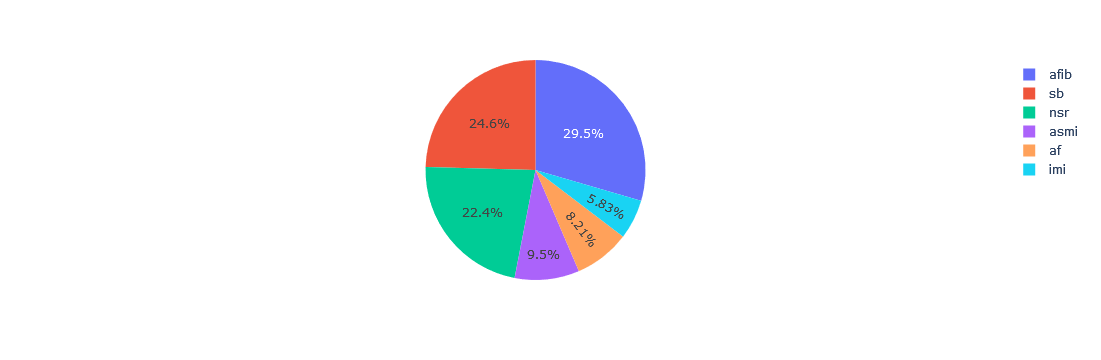

In [ ]:
df_result = pd.DataFrame(df["Diagnosis"].value_counts())
df_result = df_result.reset_index()
df_result.columns = ["Diagnosis","Total"]
df_result.head()
fig = px.pie(df_result,
             values='Total',
             names='Diagnosis')
fig.show()

Display Random Images


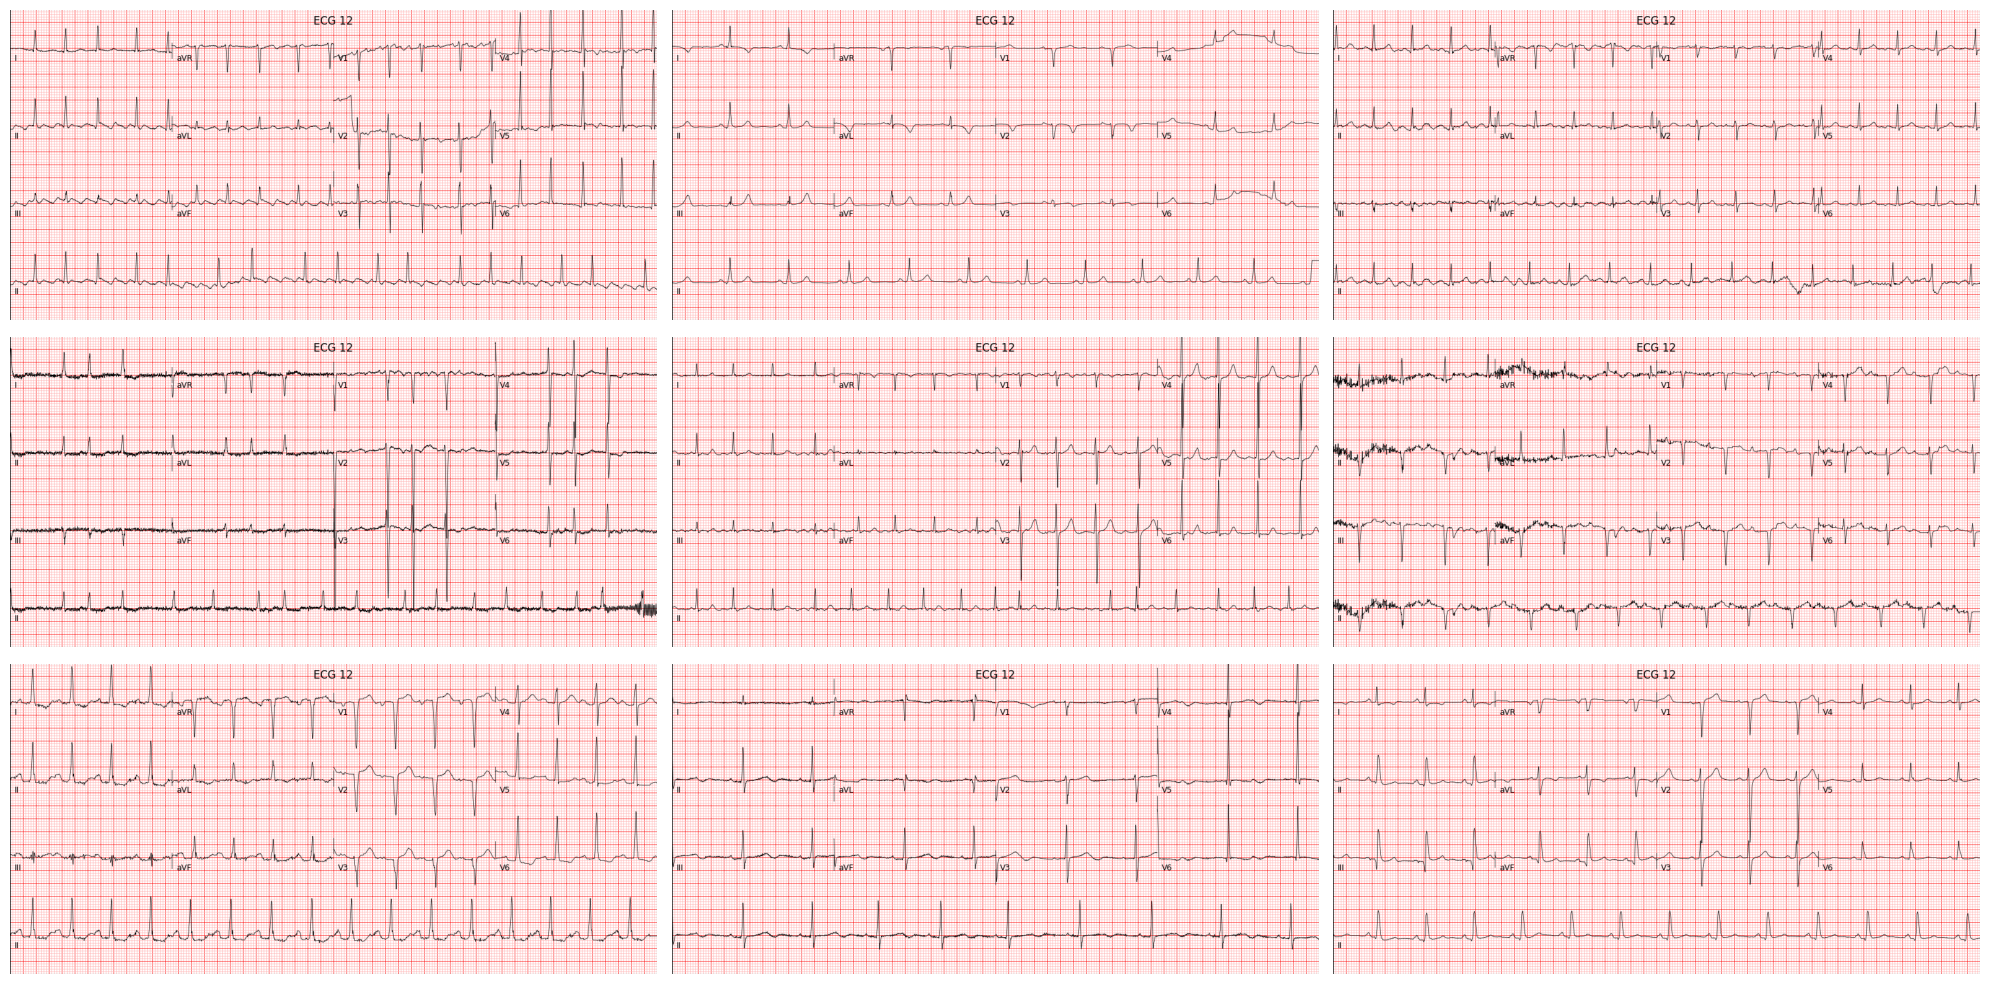

In [ ]:
Images = df["Directory"].values
random_images = [np.random.choice(Images) for i in range(9)]
print("Display Random Images")
plt.figure(figsize=(20,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    img = plt.imread(os.path.join(random_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.tight_layout()


The dimensions of the image are 1000 pixels width and 480 pixels height
The maximum pixel value is  1.000000 and the minimum is  0.000000
The mean value of the pixels is  0.910071 and the standard deviation is  0.196306


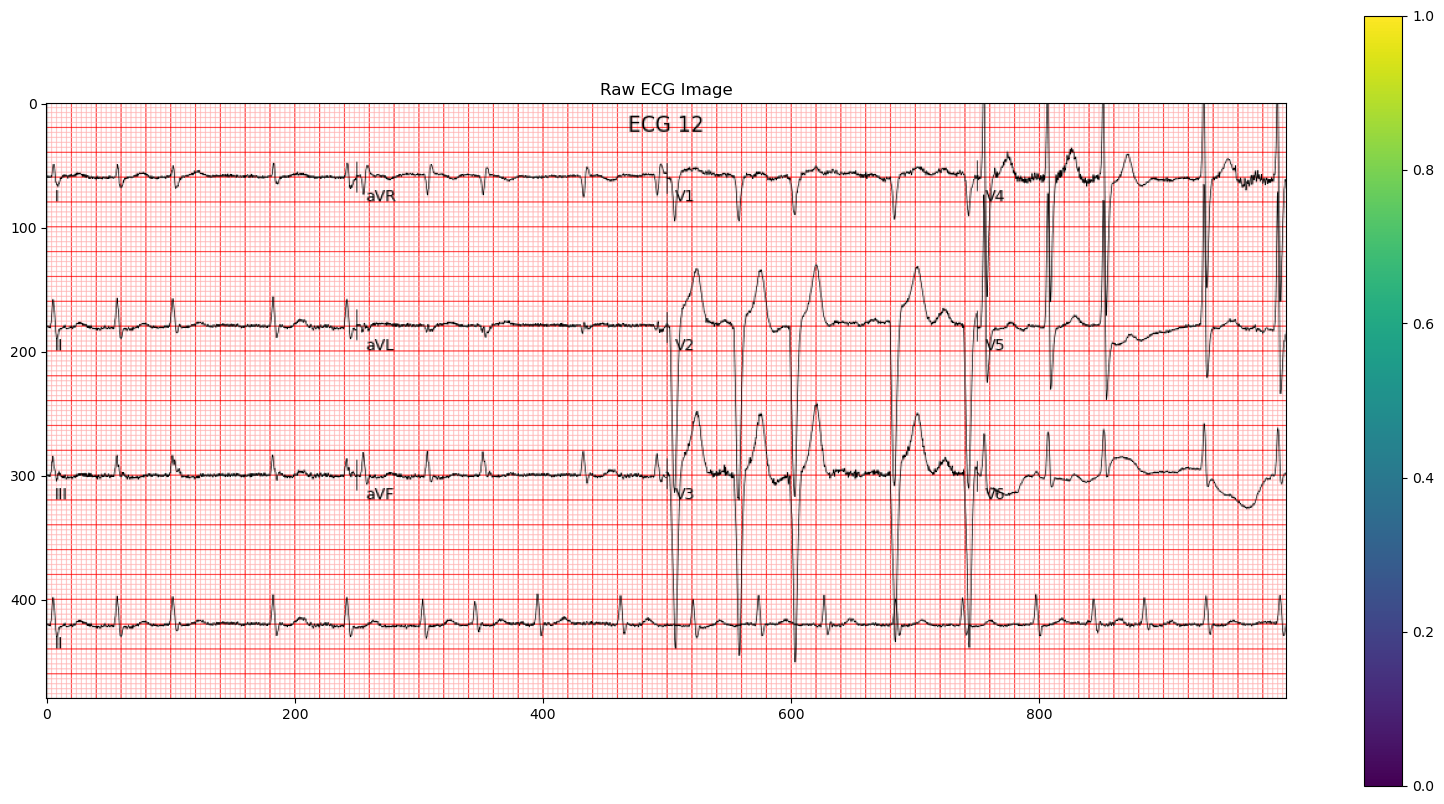

In [ ]:
sample_img = df.Directory[0]
raw_image = plt.imread(os.path.join(sample_img))
plt.figure(figsize=(20,10))
plt.imshow(raw_image)
plt.colorbar()
plt.title('Raw ECG Image')
print(f"The dimensions of the image are {raw_image.shape[1]} pixels width and {raw_image.shape[0]} pixels height")
print(f"The maximum pixel value is {raw_image.max(): 4f} and the minimum is {raw_image.min(): 4f}")
print(f"The mean value of the pixels is {raw_image.mean(): 4f} and the standard deviation is {raw_image.std(): 4f}")

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10136\570991477.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




Text(0, 0.5, '# pixels in image')

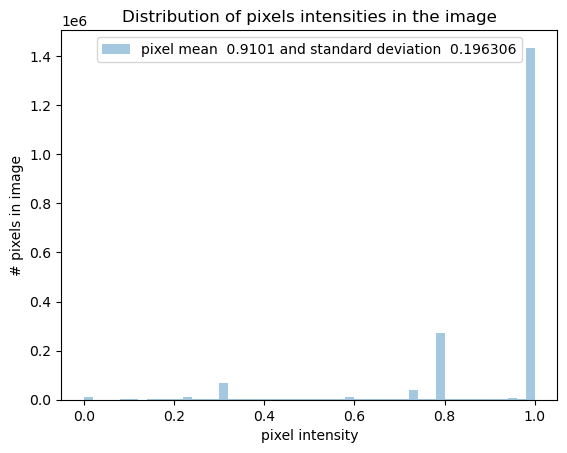

In [ ]:
sns.distplot(raw_image.ravel(), label=f"pixel mean {np.mean(raw_image): .4f} and standard deviation {np.std(raw_image): 4f}",kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of pixels intensities in the image')
plt.xlabel('pixel intensity')
plt.ylabel('# pixels in image')

## Image Pre-Processing

In [ ]:
Image_generator = ImageDataGenerator(
    samplewise_center = True,
    samplewise_std_normalization=True)

In [ ]:
#Standardize the images
train_generator=Image_generator.flow_from_dataframe(
    dataframe=df_train,
    directory= None,
    x_col="Directory",
    y_col="Diagnosis",
    class_mode = "categorical",
    subset="training",
    batch_size=1,
    seed=42,
    shuffle=False,
    target_size=(512,920))
valid_generator=Image_generator.flow_from_dataframe(
    dataframe=df_validation,
    directory= None,
    x_col="Directory",
    y_col="Diagnosis",
    class_mode = "categorical",
    ubset="validation",
    batch_size=1,
    seed=42,
    shuffle=False,
    target_size=(512,920))
#test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=Image_generator.flow_from_dataframe(
    dataframe=df_test,
    directory= None,
    x_col="Directory",
    y_col="Diagnosis",
    class_mode = "categorical",
    #subset="validation",
    batch_size=1,
    seed=42,
    shuffle=False,
    target_size=(512,920))


Found 1031 validated image filenames belonging to 6 classes.
Found 149 validated image filenames belonging to 6 classes.
Found 294 validated image filenames belonging to 6 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<function matplotlib.pyplot.colorbar(mappable: 'ScalarMappable | None' = None, cax: 'matplotlib.axes.Axes | None' = None, ax: 'matplotlib.axes.Axes | Iterable[matplotlib.axes.Axes] | None' = None, **kwargs) -> 'Colorbar'>

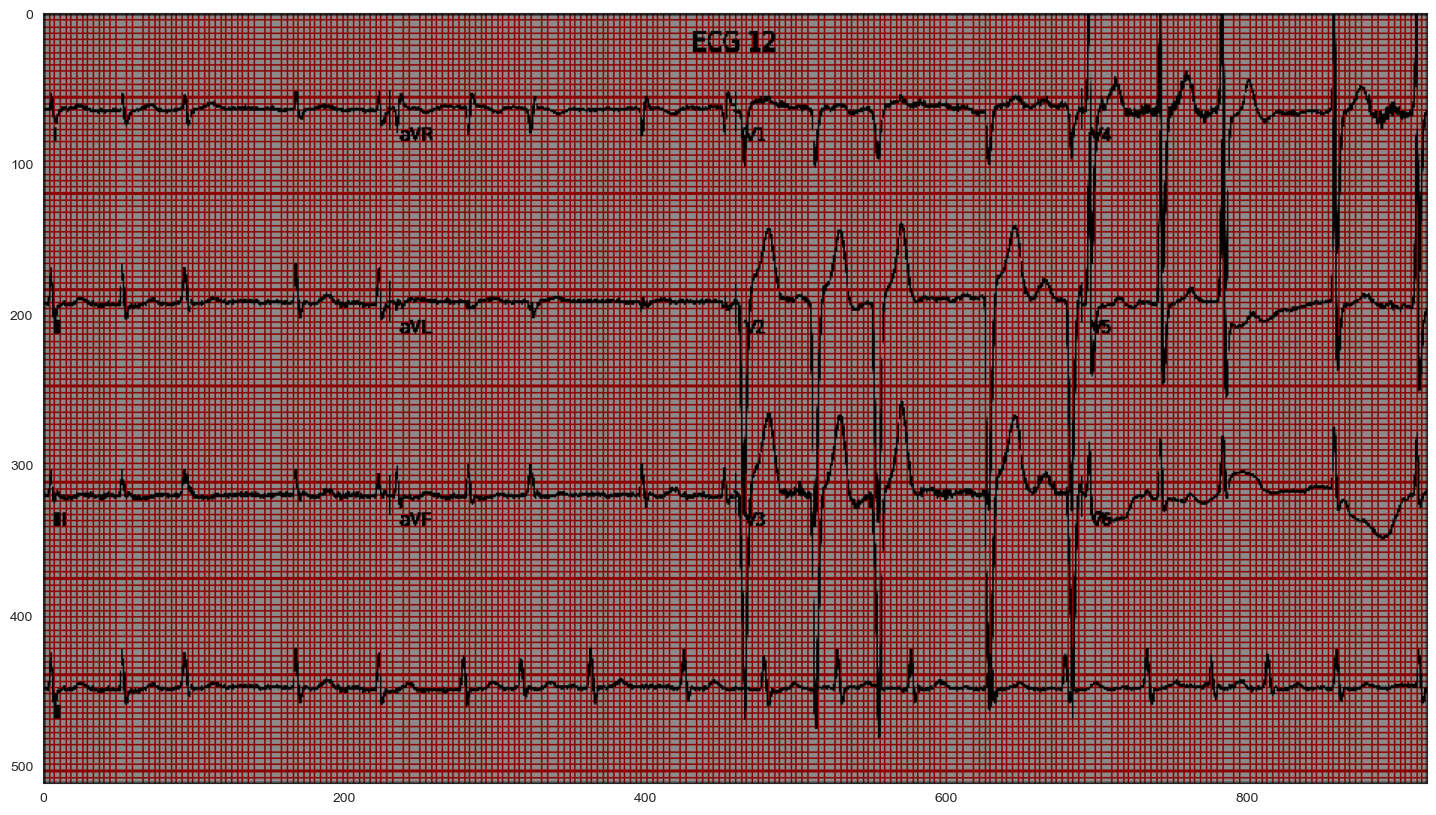

In [ ]:
sns.set_style("white")
generated_image, label = train_generator.__getitem__(0)
plt.figure(figsize=(20,10))
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10136\3004795301.py:4: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10136\3004795301.py:8: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




Text(0, 0.5, '# pixels in image')

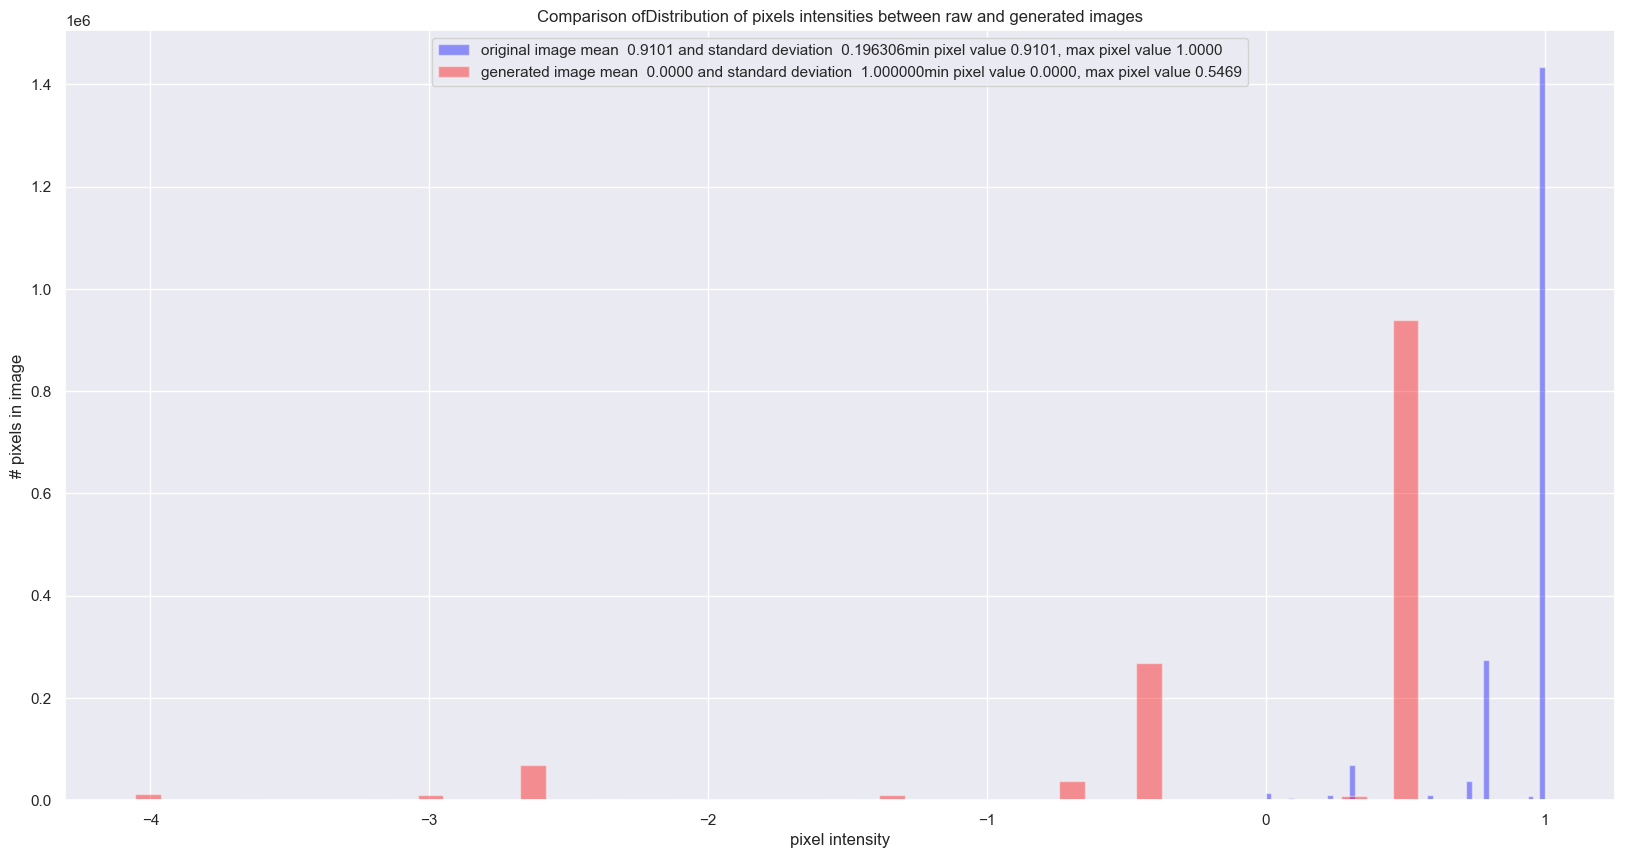

In [ ]:
sns.set()
#generated_image, label = generator.__getitem__(0)
plt.figure(figsize=(20,10))
sns.distplot(raw_image.ravel(), label=f"original image mean {np.mean(raw_image): .4f} and standard deviation {np.std(raw_image): 4f}"
             f"min pixel value {np.mean(raw_image):.4f}, max pixel value {np.max(raw_image):.4f}",
            color="blue",
            kde=False)
sns.distplot(generated_image.ravel(), label=f"generated image mean {np.mean(generated_image): .4f} and standard deviation {np.std(generated_image): 4f}"
             f"min pixel value {np.mean(generated_image):.4f}, max pixel value {np.max(generated_image):.4f}",
            color="red",
            kde=False)
plt.legend(loc='upper center')
plt.title('Comparison ofDistribution of pixels intensities between raw and generated images')
plt.xlabel('pixel intensity')
plt.ylabel('# pixels in image')

## Class Imbalance

In [ ]:
# weighted loss function for multiclass classification

## Model development

In [ ]:
# dnn_model = Sequential()
# dnn_model.add(Lambda(lambda x: x, input_shape=(512, 920, 3)))

In [ ]:
# imported_model= ResNet50(include_top=False, input_shape=(512,920,3), pooling='avg',classes=6, weights='imagenet')
# for layer in imported_model.layers:
#     layer.trainable=False

In [ ]:
# dnn_model.add(imported_model)
# dnn_model.add(Flatten())
# dnn_model.add(Dense(512, activation='relu'))
# dnn_model.add(Dense(6, activation='softmax'))

In [ ]:
# dnn_model.summary()

In [ ]:
# Set Optimizer
#dnn_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy', 'AUC'])

In [ ]:
# history = dnn_model.fit(
#     train_generator,
#     validation_data=valid_generator,
#     epochs=50
# )

In [ ]:
savedHistory=np.load('resnet_history.npy',allow_pickle='TRUE').item()

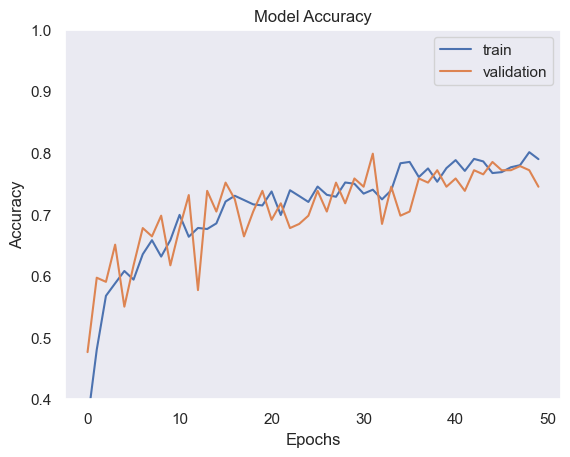

In [ ]:
fig1 = plt.gcf()
plt.plot(savedHistory['accuracy'])
plt.plot(savedHistory['val_accuracy'])
plt.axis(ymin=0.4, ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

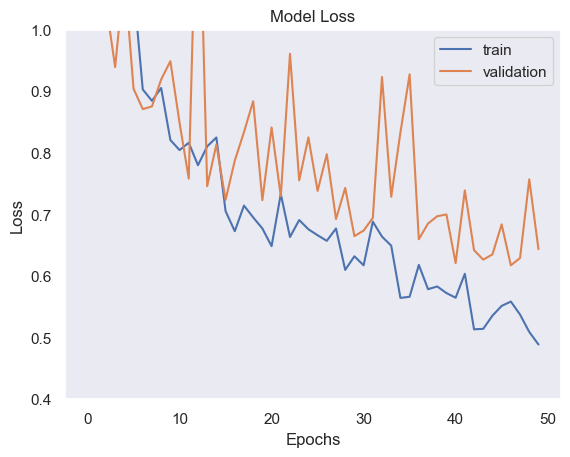

In [ ]:
fig2 = plt.gcf()
plt.plot(savedHistory['loss'])
plt.plot(savedHistory['val_loss'])
plt.axis(ymin=0.4, ymax=1)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

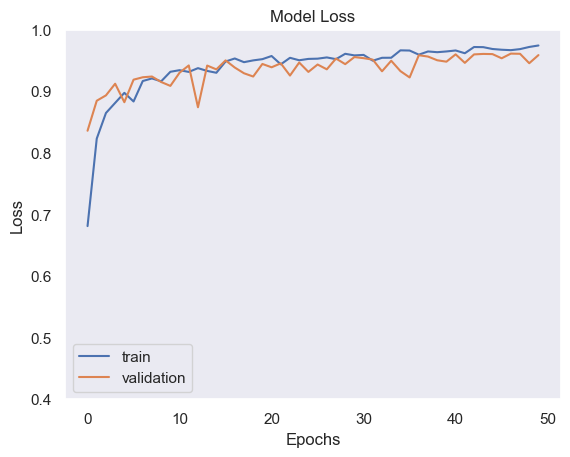

In [ ]:
fig3 = plt.gcf()
plt.plot(savedHistory['AUC'])
plt.plot(savedHistory['val_AUC'])
plt.axis(ymin=0.4, ymax=1)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
savedModel=load_model('ecgResnet2.h5')
#savedModel.summary()

In [ ]:
# use save models to make prediction on test data in real time
#model_pred=savedModel.predict(test_generator)

# just to save time, we can use this saved model predictions on test data
modelPred = np.load('savedModelTestPredictions.npy', allow_pickle=True).item()
model_pred = modelPred['pred']

In [ ]:
#savedModel.evaluate(test_generator,verbose=1)

In [ ]:
test_labels=[]
for i in range(294):
    img, label = test_generator.__getitem__(i)
    test_labels.append(list(label[0]))

#test_labels

In [ ]:
pred_list=[]
for z in range(len(model_pred)):
    pred_list.append(list(model_pred[z]))

#pred_list

In [ ]:
img_pred_list_z = []
for i in range(294):
    img_dictz = {}
    pred_listz = pred_list[i]
    # start here
    max_pred =  max(pred_listz)
    pred_index = pred_listz.index(max_pred)
    label_listzz = test_labels[i]
    max_label = max(label_listzz)
    label_index = label_listzz.index(max_label)
    #print(f"Status: {int(round(max_pred)) == int(max_label) and pred_index == label_index}, Pred_index: {pred_index}, Label_index: {label_index}, Max: {int(max_label)} : {int(round(max_pred))}")
    # pred_listz2 = [int(round(x)) for x in pred_listz]
    # label_listz = [int(x) for x in list(labelz[0])]
    img_dictz[f'ECG Test {i}'] = (int(round(max_pred)) == int(max_label) and pred_index == label_index) #correct this arrangement to ECG Test: number
    img_dictz['status'] = f"{"Correct" if (int(round(max_pred)) == int(max_label) and pred_index == label_index) else "Incorrect"}"
    img_dictz['pred'] = f"class {pred_index}"
    img_dictz['class'] = f"class {label_index}"
    img_pred_list_z.append(img_dictz)

#img_pred_list_z

In [ ]:
class_dctz= []
for i in img_pred_list_z:
    class_dctz.append(i['class'])

class_dfz = pd.DataFrame(class_dctz, columns=['classes'])
#class_dfz.head()

class_df_resultz = pd.DataFrame(class_dfz['classes'].value_counts())
class_df_resultz = class_df_resultz.reset_index()
class_df_resultz.columns = ["Classes","Total"]
#class_df_resultz.head()

test_df_resultz = pd.DataFrame(df_test['Diagnosis'].value_counts())
test_df_resultz = test_df_resultz.reset_index()
test_df_resultz.columns = ["Diagnosis","Total"]
#test_df_resultz.head()

merged_dfz = test_df_resultz.merge(class_df_resultz, how='right')
#merged_dfz.head()

In [ ]:
img_pred_listz2 = []
full_namez = {'af': 'Atrial Flutter', 'afib':'Atrial Fibrillation', 'asmi':'Anteroseptal Myocardial Infarction', 'imi':'Inferior myocardial Infarction', 'sb':'Sinus Bradycardia', 'nsr':'Normal Sinus Rythm'}
for i in img_pred_list_z:
    Diagnosisz = f"{merged_dfz[merged_dfz['Classes']==i['class']]['Diagnosis'].item()}"
    i['real_class'] = Diagnosisz
    i['real_classname'] = full_namez[Diagnosisz]
    Diagnosisz2 = f"{merged_dfz[merged_dfz['Classes']==i['pred']]['Diagnosis'].item()}"
    i['pred_class'] = Diagnosisz2
    i['pred_classname'] = full_namez[Diagnosisz2]
    img_pred_listz2.append(i)

# for z in img_pred_listz2:
#     print(z)

In [ ]:
rows = []
for a in img_pred_listz2:
    rows.append(list(a.values()))
columns = list(img_pred_listz2[0].keys())
columns

tst_result = pd.DataFrame(rows, columns= columns)
tst_result = tst_result.drop(columns[0], axis=1)
# tst_result.head()

In [ ]:
afib_res = tst_result[tst_result['real_class']=='afib']
af_res = tst_result[tst_result['real_class']=='af']
asmi_res = tst_result[tst_result['real_class']=='asmi']
imi_res = tst_result[tst_result['real_class']=='imi']
nsr_res = tst_result[tst_result['real_class']=='nsr']
sb_res = tst_result[tst_result['real_class']=='sb']

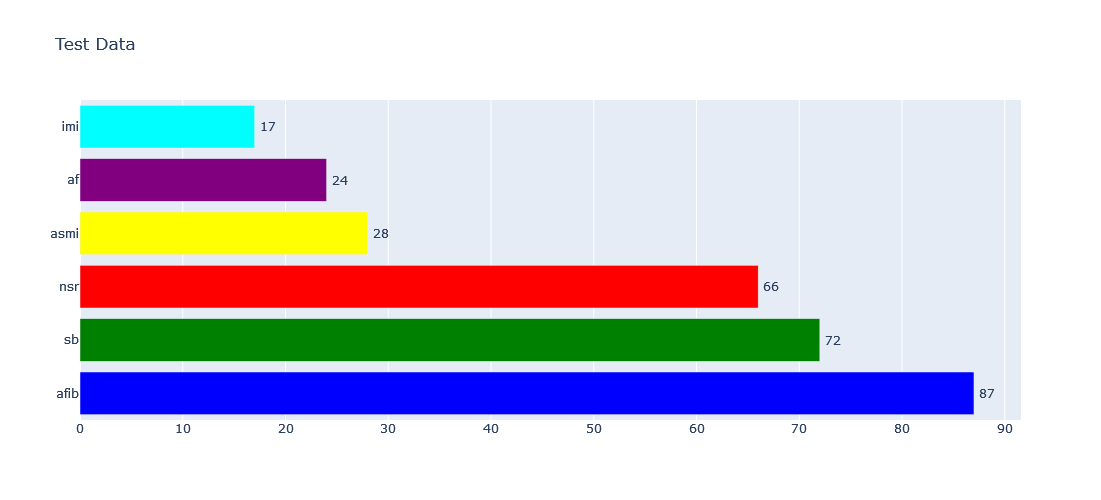

In [ ]:
x = test_df_resultz['Diagnosis'].to_numpy()
y = test_df_resultz['Total'].to_numpy()

colours = ["Blue","green","Red","Yellow", "Purple", "cyan"]

data_fig = go.Figure(data=[go.Bar(x=y,
                                y=x,
                                text=y,
                                textposition="outside",
                                marker_color=colours,
                                 orientation='h')])

data_fig.update_layout(width=1000, height=500)
data_fig.update_layout(title_text="Test Data")

data_fig.show()

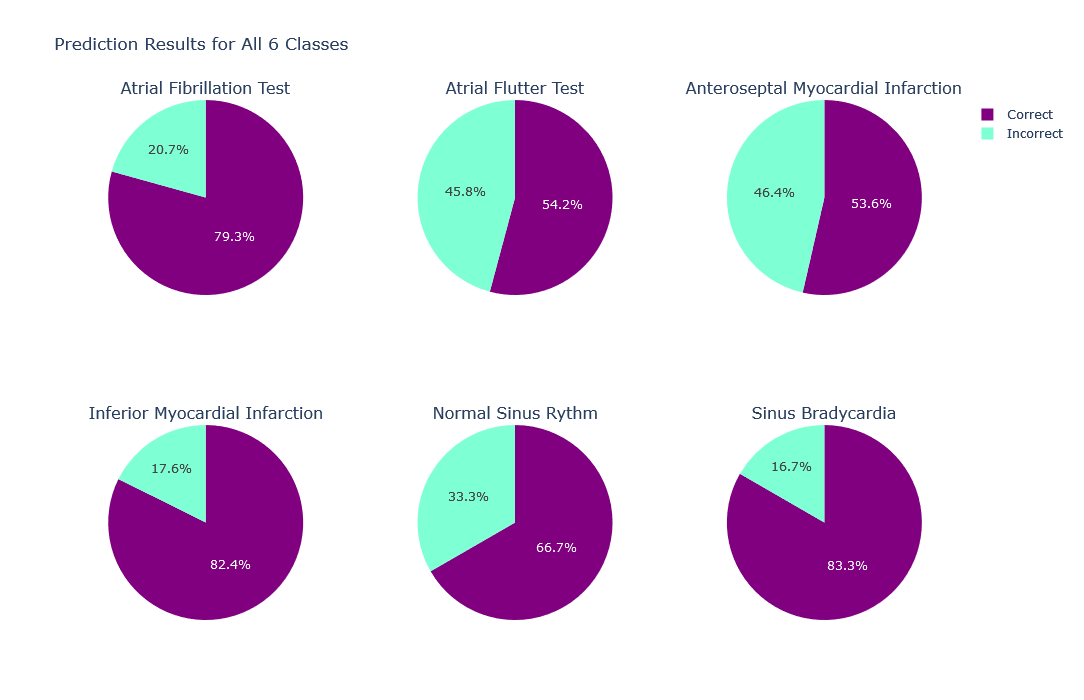

In [ ]:
df_res_afib = pd.DataFrame(afib_res['status'].value_counts())
df_res_afib = df_res_afib.reset_index()
df_res_afib.columns = ["Status","Total"]

# af
df_res_af = pd.DataFrame(af_res['status'].value_counts())
df_res_af = df_res_af.reset_index()
df_res_af.columns = ["Status","Total"]

#asmi
df_res_asmi = pd.DataFrame(asmi_res['status'].value_counts())
df_res_asmi = df_res_asmi.reset_index()
df_res_asmi.columns = ["Status","Total"]

#imi
df_res_imi = pd.DataFrame(imi_res['status'].value_counts())
df_res_imi = df_res_imi.reset_index()
df_res_imi.columns = ["Status","Total"]

# nsr
df_res_nsr = pd.DataFrame(nsr_res['status'].value_counts())
df_res_nsr = df_res_nsr.reset_index()
df_res_nsr.columns = ["Status","Total"]

# sb
df_res_sb = pd.DataFrame(sb_res['status'].value_counts())
df_res_sb = df_res_sb.reset_index()
df_res_sb.columns = ["Status","Total"]

fig = make_subplots(
    rows=2, cols=3,
    specs=[[{'type': 'domain'}, {'type': 'domain'}, {'type': 'domain'}], [{'type': 'domain'}, {'type': 'domain'}, {'type': 'domain'}]],
    subplot_titles=("Atrial Fibrillation Test", "Atrial Flutter Test", "Anteroseptal Myocardial Infarction","Inferior Myocardial Infarction", "Normal Sinus Rythm", "Sinus Bradycardia"))
fig.add_trace(go.Pie(labels=df_res_afib['Status'].to_numpy(), values=df_res_afib['Total'].to_numpy()), 1, 1)
fig.add_trace(go.Pie(labels=df_res_af['Status'].to_numpy(), values=df_res_af['Total'].to_numpy()), 1, 2)
fig.add_trace(go.Pie(labels=df_res_asmi['Status'].to_numpy(), values=df_res_asmi['Total'].to_numpy()), 1, 3)
fig.add_trace(go.Pie(labels=df_res_imi['Status'].to_numpy(), values=df_res_imi['Total'].to_numpy()), 2, 1)
fig.add_trace(go.Pie(labels=df_res_nsr['Status'].to_numpy(), values=df_res_nsr['Total'].to_numpy()), 2, 2)
fig.add_trace(go.Pie(labels=df_res_sb['Status'].to_numpy(), values=df_res_sb['Total'].to_numpy()), 2, 3)


fig.update_layout(width=1000, height=700, title_text="Prediction Results for All 6 Classes")
fig.update_traces(marker=dict(colors=['purple', 'aquamarine']))
fig.show()


In [ ]:
from tkinter import *
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tkinter import filedialog
# Create Tk root
root = Tk()
# Hide the main window
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)


infiles = filedialog.askopenfilename(multiple=True)
pdd2=[]
pdd=[]
print(infiles[0])
pdd.append(infiles[0])
pdd.append('Paper')
pdd2.append(pdd)
dfp =pd.DataFrame(pdd2, columns=["img","p"])

# imagee = infiles[0].split("/")[-1]
# print(imagee.split('.')[0])
transformed_img = Image_generator.flow_from_dataframe(
    dataframe=dfp,
    directory= None,
    x_col="img",
    y_col="p",
    class_mode = "categorical",
    batch_size=1,
    seed=42,
    shuffle=False,
    target_size=(512,920))



img, label = transformed_img.__getitem__(0) #cv2.imread(infiles[0])
image_resized= cv2.resize(img[0], (920,512))
#cv2.imshow('ECG', img[0])
#cv2.waitKey(0)
img=np.expand_dims(image_resized,axis=0)
img.shape

pred_img=savedModel.predict(img)
print(pred_img[0])
img_rec = {}
pred_list_img = list(pred_img[0])
max_pred_img =  max(pred_list_img)
pred_index_img = pred_list_img.index(max_pred_img)
img_rec['pred'] = f"class {pred_index_img}"
img_Diagnosis = f"{merged_dfz[merged_dfz['Classes']==img_rec['pred']]['Diagnosis'].item()}"
img_rec['pred_class'] = img_Diagnosis
img_rec['pred_classname'] = full_namez[img_Diagnosis]
img_rec['score'] = max_pred_img

print(img_rec)
%gui tk




C:/Users/Administrator/Desktop/dawsonAI/ECGSegmentation/data/asmi/00526_hr.png
Found 1 validated image filenames belonging to 1 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
[1.7497494e-04 6.0966429e-03 4.9789920e-01 3.1876376e-01 7.3278047e-02
 1.0378739e-01]
{'pred': 'class 2', 'pred_class': 'asmi', 'pred_classname': 'Anteroseptal Myocardial Infarction', 'score': 0.4978992}
